Chapter 5: Training ML models with Serotiny
Suggested: Alex, Gui
- Quick explanation of serotiny’s yaml-based task formulation
- Show how one can start a simple training based on 2D images to classify, e.g. edge vs. non-edge cells
- Show how one can load and apply the trained model
- Show how to bring in a pretrained model (2D RESNET)
- Show that we can use the latent space from 3D images (which has been precomputed and stored)



# **Serotiny in a nutshell**

`serotiny` is a Python package and framework to help you create configurable and reproducible DL projects. It uses [hydra](https://hydra.cc/) for configurability, [MLFlow](https://mlflow.org/) for experiment tracking,
and [Pytorch Lightning](https://pytorchlightning.ai/) for DL model training/testing/predictions.

## **Project structure**
With `serotiny` a DL project has a predefined structure (which this repo already complies with). To start a new project with the appropriate structure, you can use the [serotiny-project cookiecutter](https://github.com/allencellmodeling/serotiny-project-cookiecutter)

A serotiny project contains a Python package, and a config folder. This config folder is composed of 5 config groups:

- `data` : where we configure access to datasets

- `model` : where we define and parameterize models/networks

- `trainer` : where we setup the Pytorch Lightning trainer

- `trainer/callbacks` : where we (optionally) add a list of callbacks to be run in train/test/prediction

- `mlflow`: where we configure access to a MLFlow server, where our experiments and results will be tracked and stored

## **`serotiny` commands**
Aside from the predefined structure and config folder, `serotiny` has set of commands which know how to read a project's configuration (and override it)
and execute DL tasks.

For example, we could train a model using the a model config called `my_classifier` (which would live in `config/model/my_classifier.yaml`), and a data config
called `my_train_data` (which would live in `config/data/my_train_data.yaml`) and overriding some of the `mlflow` config parameters.
<br><small>Note: Because we didn't specify a top-level `mlflow` config, i.e. we didn't do `mlflow=...`, `serotiny` will use the default config, which lives in `config/mlflow/default.yaml`</small>

```
$ serotiny train model=my_classifier data=my_train_data mlflow.experiment_name=some_experiment mlflow.run_name=1st_run
```

Once the model finishes training, we could use it to make predictions on a different dataset, configured in `my_predict_data`

```
$ serotiny predict model=my_classifier data=my_predict_data mlflow.experiment_name=some_experiment mlflow.run_name=1st_run
```


# **Getting started**

In [2]:
import logging
logging.getLogger("bfio").setLevel(logging.ERROR)
logging.getLogger("bfio.backends").setLevel(logging.ERROR)
logging.getLogger("aicsimageio").setLevel(logging.ERROR)

from upath import UPath as Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nbvv

from serotiny.io.image import image_loader
from cytodata_aics.io_utils import rescale_image

## Load the manifest and explore dimensions

In [10]:
cells_df = pd.read_parquet("s3://variance-dataset/processed/manifest.parquet")
print(f"Number of cells: {len(cells_df)}")
print(f"Number of columns: {len(cells_df.columns)}")

Number of cells: 215081
Number of columns: 1242


## Make a simple dataset of edge vs. non-edge cells

In [25]:
from serotiny.transforms.dataframe.transforms import split_dataframe

Path("/home/aicsuser/serotiny_data/").mkdir(parents=True, exist_ok=True)

n = 1000 # number of cells per class
cells_edgeVSnoedge = cells_df.groupby("edge_flag").sample(n)

# Add the train, test and validate split
cells_edgeVSnoedge = split_dataframe(dataframe=cells_edgeVSnoedge, train_frac=0.7, val_frac=0.2, return_splits=False)

cells_edgeVSnoedge.to_csv("/home/aicsuser/serotiny_data/cells_edgeVSnoedge.csv") 
print(f"Number of cells: {len(cells_edgeVSnoedge)}")
print(f"Number of columns: {len(cells_edgeVSnoedge.columns)}")

Number of cells: 2000
Number of columns: 1243


## Visualize some non-edge cell

In [32]:
some_cell = cells_edgeVSnoedge[cells_edgeVSnoedge.edge_flag == 0].sample(1).iloc[0]

img = image_loader(
    some_cell.registered_path,
    transform=lambda img: rescale_image(img,
                                        channels=['bf', 'dna', 'membrane', 'structure',
                                                  'dna_segmentation', 'membrane_segmentation', 'struct_segmentation_roof']),
    return_as_torch=False
)

img.shape

(7, 136, 245, 381)

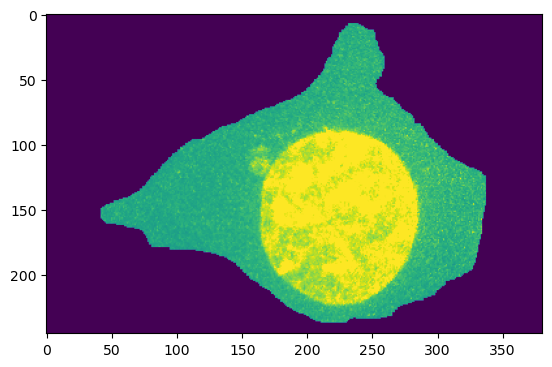

In [31]:
plt.imshow(img[1].max(axis=0))
plt.show()

## Visualize some edge cell

In [33]:
some_cell = cells_edgeVSnoedge[cells_edgeVSnoedge.edge_flag == 1].sample(1).iloc[0]

img = image_loader(
    some_cell.registered_path,
    transform=lambda img: rescale_image(img,
                                        channels=['bf', 'dna', 'membrane', 'structure',
                                                  'dna_segmentation', 'membrane_segmentation', 'struct_segmentation_roof']),
    return_as_torch=False
)

img.shape

(7, 136, 245, 381)

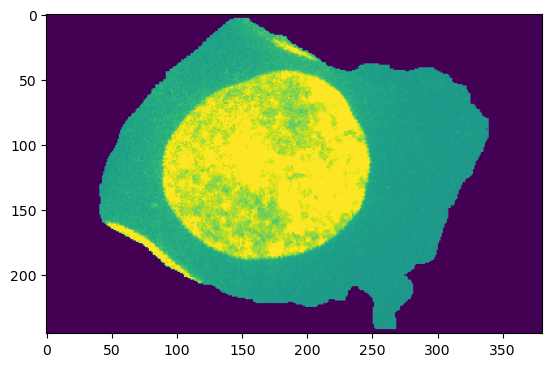

In [34]:
plt.imshow(img[1].max(axis=0))
plt.show()